### This is based on pytorch tutorial:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

#### Install pycocotools, the version by default in Colab has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354

In [2]:
%%shell
wget https://drive.google.com/file/d/1V5X98zLvRNKnCBFQ8sc1gyljNcwaZEyV/view?usp=sharing

--2021-04-05 17:00:58--  https://drive.google.com/file/d/1V5X98zLvRNKnCBFQ8sc1gyljNcwaZEyV/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.73.206, 2607:f8b0:4004:832::200e
Connecting to drive.google.com (drive.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  62.40K  --.-KB/s    in 0.005s  

2021-04-05 17:00:58 (11.1 MB/s) - ‘view?usp=sharing’ saved [63896]



In [3]:
%%shell
gdown --id 1V5X98zLvRNKnCBFQ8sc1gyljNcwaZEyV

Downloading...
From: https://drive.google.com/uc?id=1V5X98zLvRNKnCBFQ8sc1gyljNcwaZEyV
To: /content/archive.zip
12.4GB [04:42, 43.7MB/s]


In [ ]:
!unzip archive.zip

In [5]:
!rm -rf archive.zip

In [ ]:
%%shell

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-1aizxzf5
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-1aizxzf5
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263918 sha256=06762054d6655535bfffc8de8ab024240d54edb5efe1177bfcba05871947e98f
  Stored in directory: /tmp/pip-ephem-wheel-cache-rltb_edf/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


## Defining the Dataset


* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.


### Writing a custom dataset for Penn-Fudan

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [ ]:
%%shell

rm -rf PennFundanPed.zip
rm -rf PennFundanPed
# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2021-03-28 17:24:33--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.2’

PennFudanPed.zip.2  100%[===================>]  51.23M   247MB/s    in 0.2s    

2021-03-28 17:24:33 (247 MB/s) - ‘PennFudanPed.zip.2’ saved [53723336/53723336]

--2021-03-28 17:24:33--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-03-28 17:24:33--
Total wall clock time: 0.3s
Downloaded: 1 files, 51M in 0.2s (247 MB/s)
Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: PennFudanPed/added-object-list.txt  
  inflating: PennFudanPed/Annotation/FudanPed00001.t

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [ ]:
from PennFundanDataset import PennFudanDataset
from ImageDirtier import ImageDirtier
from Prepare import get_instance_segmentation_model
import cv2
import numpy as np
import os
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image

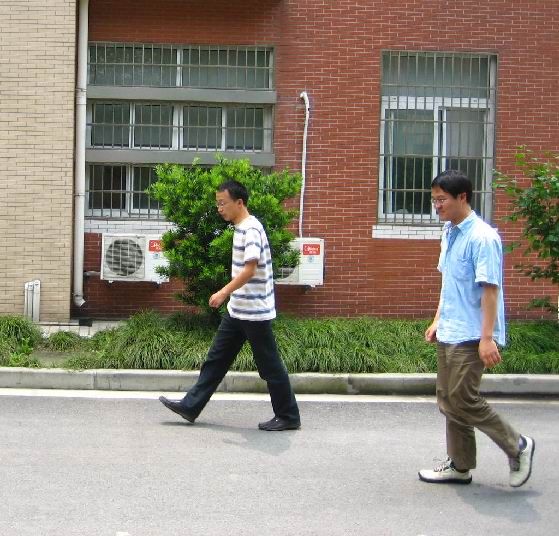

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

In [ ]:
def generate_random_lines(imshape,slant,drop_length):    
  drops=[]    
  for i in range(50): ## If You want heavy rain, try increasing this        
    if slant<0:           
      x= np.random.randint(slant,imshape[1])        
    else:            
      x= np.random.randint(0,imshape[1]-slant)        
    y= np.random.randint(0,imshape[0]-drop_length)        
    drops.append((x,y))    
  return drops
        
def add_rain(image):        
  imshape = image.shape    
  slant_extreme=10    
  slant= np.random.randint(-slant_extreme,slant_extreme)     
  drop_length=20    
  drop_width=2    
  drop_color=(200,200,200) ## a shade of gray    
  rain_drops= generate_random_lines(imshape,slant,drop_length)        
  for rain_drop in rain_drops:        
    cv2.line(image,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)    
  image= cv2.GaussianBlur(image,(7,7),2.0) ## rainy view are blurry          
  return image

In [ ]:
def add_blur(image, x,y,hw):    
  image[y:y+hw, x:x+hw,1] = image[y:y+hw, x:x+hw,1]+1    
  image[:,:,1][image[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
  image[y:y+hw, x:x+hw,1] = cv2.GaussianBlur(image[y:y+hw, x:x+hw,1] ,(31,31),1.0)    
  return image

def generate_random_blur_coordinates(imshape,hw):    
  blur_points=[]   
  midx= imshape[1]//2-hw-100
  midy= imshape[0]//2-hw-100
  index=1    
  while(midx>-30 or midy>-30): ## radially generating coordinates        
    for i in range(250*index):            
      x= np.random.randint(midx,imshape[1]-midx-hw)            
      y= np.random.randint(midy,imshape[0]-midy-hw)            
      blur_points.append((x,y))        
    midx-=250*imshape[1]//sum(imshape)        
    midy-=250*imshape[0]//sum(imshape)        
    index+=1    
  return blur_points

def add_fog(image):     
  mask = np.zeros_like(image)     
  imshape = image.shape    
  hw=100 
  haze_list= generate_random_blur_coordinates(imshape,hw)    
  for haze_points in haze_list:              
    image = add_blur(image, haze_points[0],haze_points[1], hw) ## adding all shadow polygons on empty mask, single 255 denotes only red channel    
  return image

In [ ]:
img_dirtier = ImageDirtier(15,5,10)
image = Image.open('PennFudanPed/PNGImages/FudanPed00001.png')
img, mask = img_dirtier.apply(np.array(image))

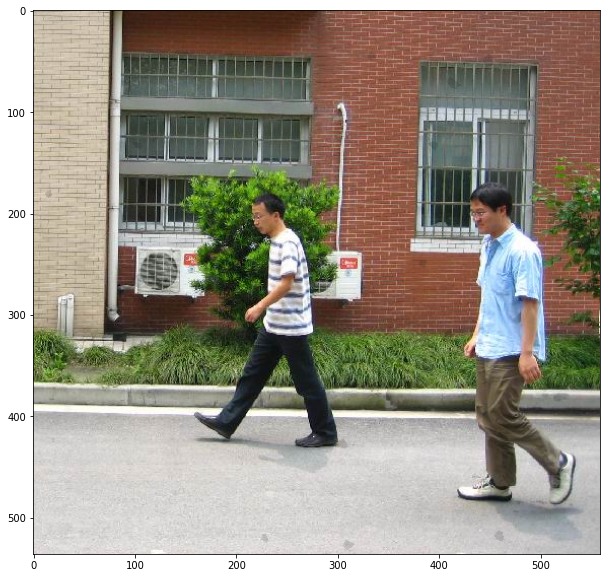

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(img)

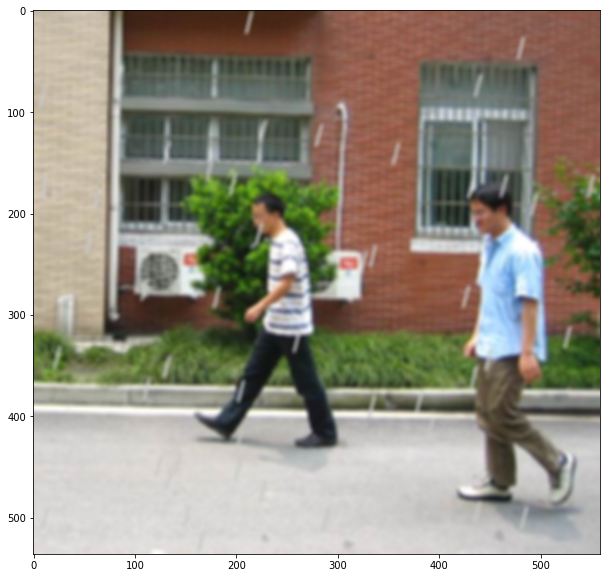

In [ ]:
img = add_rain(img)
plt.figure(figsize = (20,10))
plt.imshow(img)

(536, 559, 3)


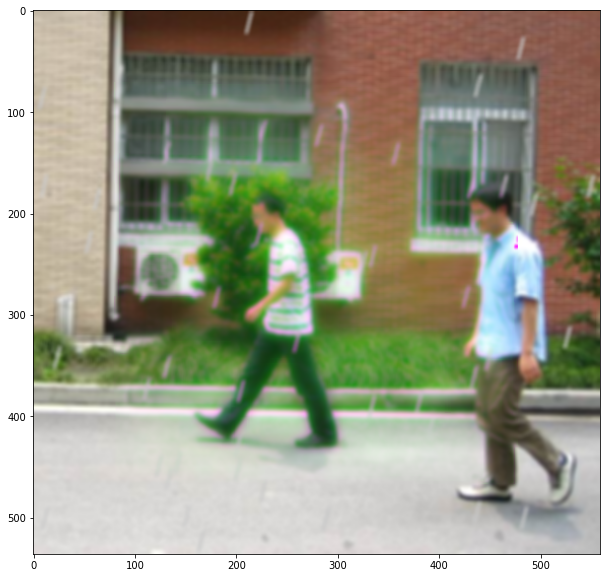

In [ ]:
print(img.shape)
img = add_fog(img)
plt.figure(figsize = (20,10))
plt.imshow(img)

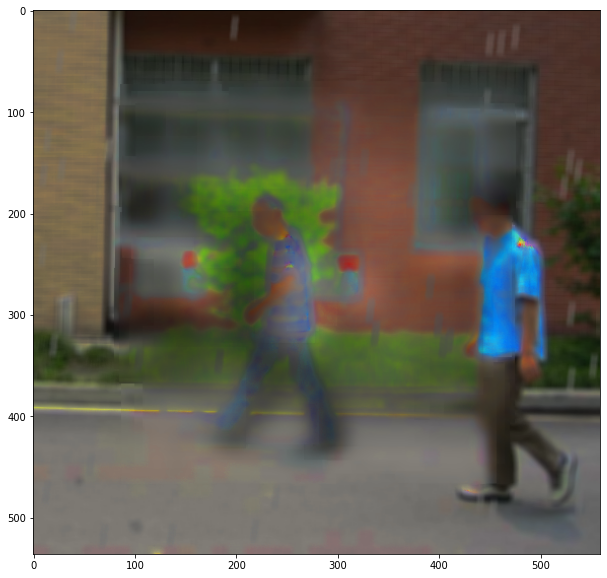

(536, 559)


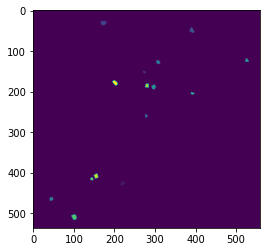

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.imshow(img)
plt.show()
print(mask.shape)
plt.imshow(mask)

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(array([[[211, 200, 182],
         [210, 199, 181],
         [212, 201, 183],
         ...,
         [143,  96,  78],
         [146,  99,  81],
         [148, 101,  83]],
 
        [[179, 168, 150],
         [173, 162, 144],
         [170, 159, 141],
         ...,
         [126,  79,  61],
         [128,  81,  63],
         [128,  81,  63]],
 
        [[204, 193, 175],
         [194, 183, 165],
         [188, 177, 159],
         ...,
         [130,  83,  65],
         [131,  84,  66],
         [130,  83,  65]],
 
        ...,
 
        [[226, 220, 220],
         [217, 211, 211],
         [211, 205, 205],
         ...,
         [183, 183, 183],
         [184, 184, 184],
         [185, 185, 185]],
 
        [[231, 225, 225],
         [219, 213, 213],
         [210, 204, 204],
         ...,
         [187, 187, 187],
         [187, 187, 187],
         [186, 186, 186]],
 
        [[225, 219, 219],
         [227, 221, 221],
         [215, 209, 209],
         ...,
         [190, 190, 190],
  

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model
Faster R-CNN

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)



In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` there is a number of helper functions to simplify training and evaluating detection models.
Here, I will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # I will maybe add more of them
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
# here I will probably add option to use some evolutionary algorithm to optimize this params, training speed will drop
# a lot if we use it but results should be better
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:02  lr: 0.000090  loss: 4.8474 (4.8474)  loss_classifier: 0.7906 (0.7906)  loss_box_reg: 0.0569 (0.0569)  loss_mask: 2.0246 (2.0246)  loss_objectness: 1.9262 (1.9262)  loss_rpn_box_reg: 0.0491 (0.0491)  time: 1.0357  data: 0.2516  max mem: 2588
Epoch: [0]  [10/60]  eta: 0:00:30  lr: 0.000936  loss: 2.7338 (3.5895)  loss_classifier: 0.4644 (0.5250)  loss_box_reg: 0.1005 (0.1505)  loss_mask: 1.0480 (1.2692)  loss_objectness: 1.1751 (1.5604)  loss_rpn_box_reg: 0.0673 (0.0844)  time: 0.6067  data: 0.0314  max mem: 2866
Epoch: [0]  [20/60]  eta: 0:00:23  lr: 0.001783  loss: 2.0507 (2.6833)  loss_classifier: 0.3681 (0.4472)  loss_box_reg: 0.2191 (0.2013)  loss_mask: 0.6399 (0.8476)  loss_objectness: 0.6784 (1.0929)  loss_rpn_box_reg: 0.0676 (0.0944)  time: 0.5621  data: 0.0088  max mem: 2866
Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.002629  loss: 1.3429 (2.2045)  loss_classifier: 0.2794 (0.3812)  loss_box_reg: 0.2454 (0.2127)  loss_mask: 0.3587 (0.6834)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, target = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

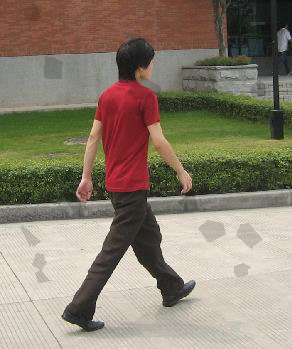

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

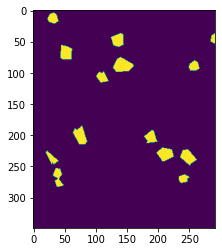

In [ ]:
all_masks = np.zeros(target['masks'][0].shape)
for mask in target['masks']:
  all_masks += mask.numpy()
plt.imshow(all_masks)
plt.show()

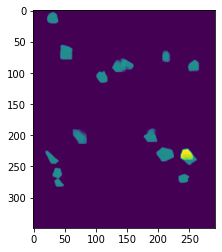

In [ ]:
all_masks = np.zeros(target['masks'][0].shape)
iterator = 0
for mask in prediction[0]['masks']:
  if prediction[0]['scores'][iterator] < 0.5:
    break
  iterator += 1
  shape = mask.to('cpu').numpy().shape
  all_masks += mask.to('cpu').numpy().reshape(shape[1],shape[2])
plt.imshow(all_masks)
plt.show()

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

0
tensor(0.9921, device='cuda:0')


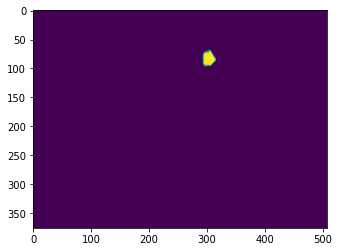

1
tensor(0.9910, device='cuda:0')


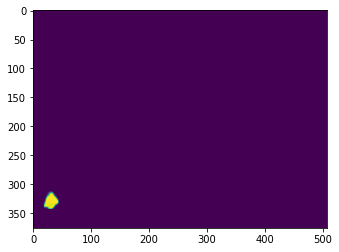

2
tensor(0.9729, device='cuda:0')


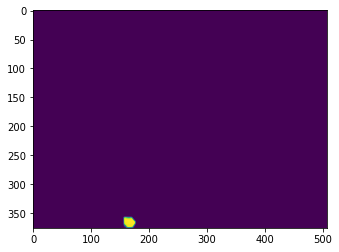

3
tensor(0.9683, device='cuda:0')


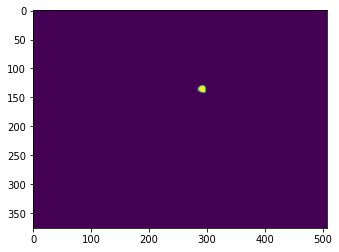

4
tensor(0.9358, device='cuda:0')


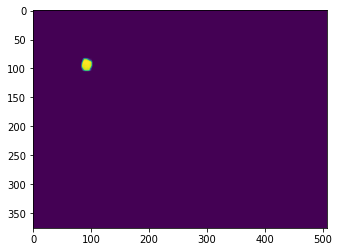

5
tensor(0.8945, device='cuda:0')


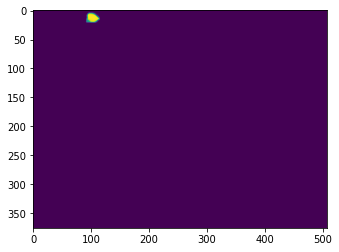

6
tensor(0.8882, device='cuda:0')


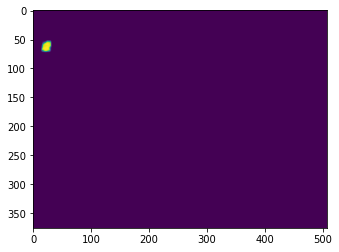

7
tensor(0.7811, device='cuda:0')


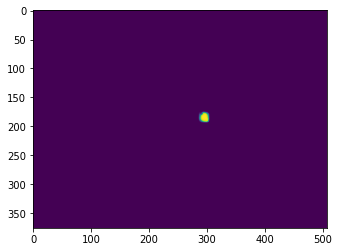

8
tensor(0.5845, device='cuda:0')


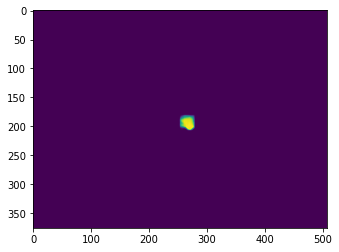

9
tensor(0.5530, device='cuda:0')


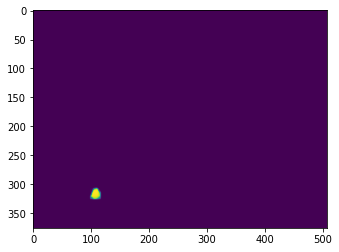

In [ ]:
for i in range(prediction[0]['masks'].shape[0]):
  if prediction[0]['scores'][i] < 0.5:
    break
  print(i)
  print(prediction[0]['scores'][i])
  mask = prediction[0]['masks'][i].permute(1,2,0).to('cpu')
  plt.imshow(mask.reshape(mask.shape[0],mask.shape[1]))
  plt.show()